# Trabajo Práctico Nº 1
## Objetivos

- Implementar y analizar el filtro de promedio móvil (moving average) en Python.
- Aplicar el concepto de convolución en señales digitales.
- Familiarizarse con el entorno de desarrollo en Python notebooks.
- Comparar representación en punto flotante vs punto fijo, evaluando precisión y tiempos de cómputo.

# Ejercicio 1 - Filtro Moving Average

1. Implementá un algoritmo de promedio móvil (moving average) según la definición vista en clase, que reciba como parámetros:

- La señal de entrada.
- El tamaño de la ventana.

A partir de tu implementación, obtené y graficá la respuesta impulsiva del sistema (lo que en clase llamamos su “firma” o función de transferencia).

2. Respondé:

- ¿Cómo se obtiene la respuesta impulsiva de cualquier sistema?

  La respuesta impulsiva se obtiene aplicando una delta de dirac como entrada del sistema. La salida, será la respuesta impulsiva del sistema, la cual sirve para observar el comportamiento con cualquier señal de entrada, ya que la salida será la convolución de esta con la respuesta impulsiva del sistema.
- ¿Qué representa en el caso del filtro de promedio móvil?

  La respuesta del filro de promedio movil obtenida es la de un filtro pasabajos. A medida que se aumenta la ventana, menor será la frecuencia de corte y, por ende, mayor será la atenuación de la señal de entrada.

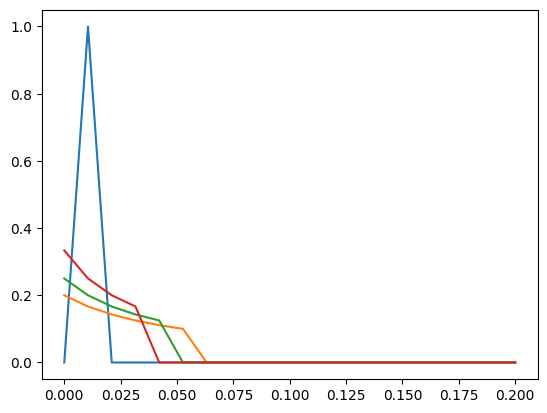

In [1]:
import scipy.signal as sig
import numpy as np
import matplotlib.pyplot as plt

def media_movil(signal, window_size):
    avg = np.zeros(len(signal))

    for n in range(len(signal)):
        suma = 0
        d = 0
        for k in range (-(window_size), window_size):
            if ((n-k) > 0) and ((n-k) < (len(signal))):
                suma = suma + signal[(n-k)]
                d = d+1
    
        avg[n] = np.copy(suma/d)
    return avg

fs = 100   # frecuencia de muestreo
mps = 20   # muestras por segundo
t = np.linspace(0,mps/fs,num=mps)

impulso = sig.unit_impulse(20,1)

plt.plot(t, impulso)
plt.plot(t, media_movil(impulso, 5))
plt.plot(t, media_movil(impulso, 4))
plt.plot(t, media_movil(impulso, 3))

# Ejercicio 2 - Respuesta del sistema

1. Genera dos señales de prueba:
    - Una onda cuadrada de amplitud 1 y frecuencia de 2 kHz.
    - Una onda triangular de amplitud 1 y frecuencia de 1 kHz.

Aplica el moving average implementado en el Ejercicio 1 a estas señales.

2. Analiza los resultados:

    - Grafica la señal original y la señal filtrada.
    - Explica qué cambios observas en la forma de onda.

3. Escribe tus conclusiones: ¿Qué efecto tiene el filtro de promedio móvil sobre cada señal?
La señales obtenidas al aplicar el filtro de media movil tienden a parecerse más a señales senoidales al filrarse sus armónicas de frecuencias superiores. También poseen menor amplitud.

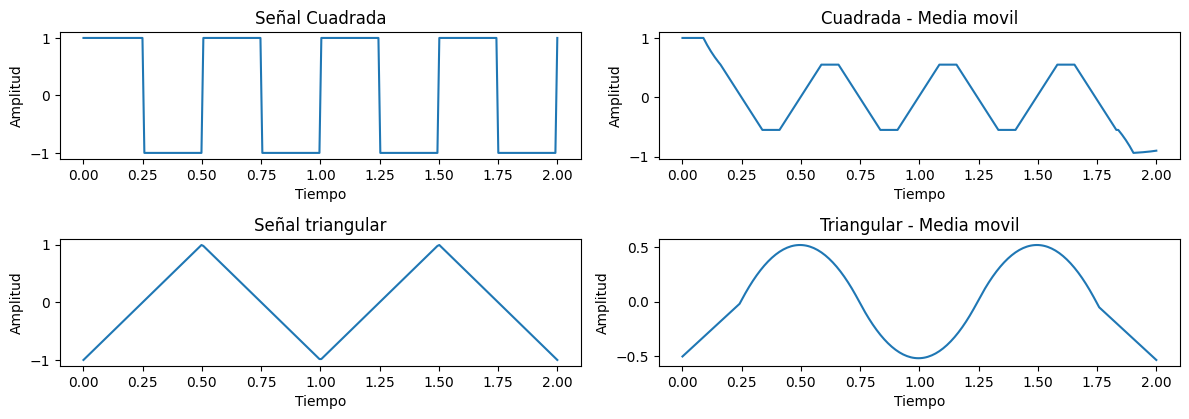

In [25]:
# Escribí tu código acá
fs = 5000
t = np.linspace(0,10/fs,num=250)

f1 = 2000
cuadrada = sig.square(2 * np.pi * f1 * t)

f2 = 1000
triangular = sig.sawtooth(2 * np.pi * t * f2, 0.5)

nt = t * 1000

plt.figure(figsize=(12, 8))

plt.subplot(4, 2, 1)
plt.plot(nt, cuadrada)
plt.title('Señal Cuadrada')
plt.xlabel('Tiempo')
plt.ylabel('Amplitud')

plt.subplot(4, 2, 2)
plt.plot(nt, media_movil(cuadrada, 20))
plt.title('Cuadrada - Media movil')
plt.xlabel('Tiempo')
plt.ylabel('Amplitud')

plt.subplot(4, 2, 3)
plt.plot(nt, triangular)
plt.title('Señal triangular')
plt.xlabel('Tiempo')
plt.ylabel('Amplitud')

plt.subplot(4, 2, 4)
plt.plot(nt, media_movil(triangular, 30))
plt.title('Triangular - Media movil')
plt.xlabel('Tiempo')
plt.ylabel('Amplitud')

# Ajustar el diseño para evitar solapamiento
plt.tight_layout()
plt.show()

# Ejercicio 3 - Convolución en punto flotante y punto fijo

1. Implementa un algoritmo de convolución:

    - En punto flotante (float).
    - En punto fijo, utilizando por ejemplo la librería fixedpoint.

2. Compara los resultados con la función de NumPy np.convolve. Mide y compara:

    - El tiempo de ejecución usando timeit.
    - El error de la salida respecto al cálculo en punto flotante.

3. Conclusión:

    - ¿Qué diferencias observas entre las implementaciones?
    - ¿Qué ventajas y desventajas tiene usar punto fijo en lugar de punto flotante?
      La convolución en punto fijo utilizando la función de convolución escrita manualmente es mucho más lenta que la utilizada por punto flotante y la librería de numpy. Esto se debe a que la librería se encuentra mucho más optimizada para realizar este tipo de tareas que las que se puedan realizar a mano, aunque se obtengan finalmente los mismos resultados.

Convolucion en punto fijo: 109.77689480781555
Convolucion en punto flotante: 0.00039887428283691406
El error al utilizar punto flotante es: 1.0299920916168048e-08


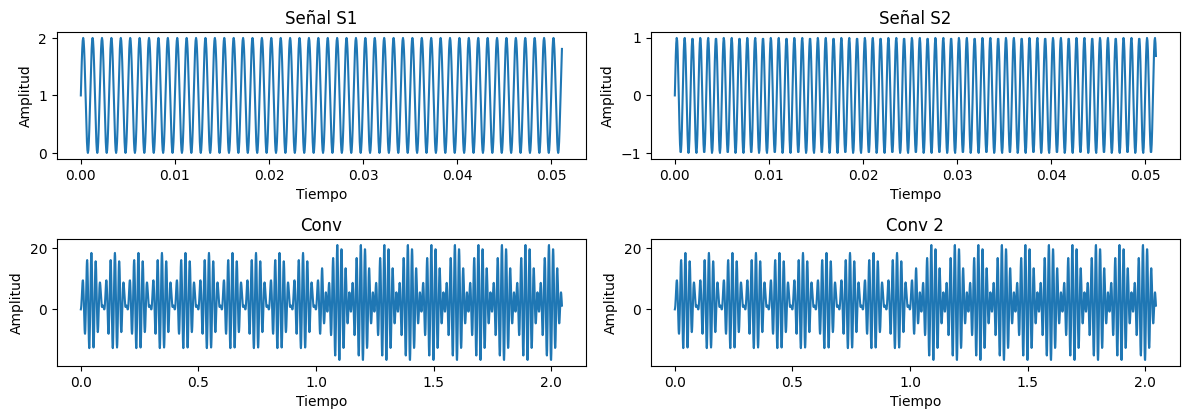

In [5]:
# Escribí tu código acá
import timeit
import time
from scipy.fft import fft, fftshift, fftfreq
from fixedpoint import FixedPoint

def convolucion(s1, s2):
    len_s1 = len(s1)
    len_s2 = len(s2)
    len_resultado = len_s1 + len_s2 - 1
    resultado = [0] * len_resultado  # Inicializar la salida con ceros

    for n in range(len_resultado):
        suma = 0
        for m in range(len_s2):
            i = n - m  # Índice en x
            if 0 <= i < len_s1:
                suma += s1[i] * s2[m]
        resultado[n] = suma

    return resultado

# Este wrapper empaqueta funciones para que el timeit pueda medir solo eso
def wrapper(func, *args):
    def wrapped():
        return func(*args)
    return wrapped

# Redefinicion de tiempo y señales
t = np.arange(0, 1024/20000, 1/20000)
s1 = np.sin(2*np.pi*1000*t)+1
s2 = np.sin(2*np.pi*1200*t)

qformat = {'signed': True, 'm': 3, 'n': 29}

fs1 = []
fs2 = []

for i in range (0, len(s1)):
    fs1.append(FixedPoint(s1[i], **qformat))
    fs2.append(FixedPoint(s2[i], **qformat))

conv = wrapper(np.convolve, s1, s2)
print (f"Primer calculo de tiempo de punto flotante: {timeit.timeit(conv, number=1)}")
conv = wrapper(convolucion, fs1, fs2)
print (f"Primer calculo de tiempo de punto fijo: {timeit.timeit(conv, number=1)}")

error = 0

for i in range(0, len(conv_r)):
    e = np.abs(conv_r[i] - float(fixed_conv_r[i]))
    if e > error:
        error = e

print(f"El error máximo cometido al utilizar punto fijo es: {error}")
plt.figure(figsize=(12, 8))

plt.subplot(4, 2, 1)
plt.plot(t, s1)
plt.title('Señal S1')
plt.xlabel('Tiempo')
plt.ylabel('Amplitud')

plt.subplot(4, 2, 2)
plt.plot(t, s2)
plt.title('Señal S2')
plt.xlabel('Tiempo')
plt.ylabel('Amplitud')

plt.subplot(4, 2, 3)
plt.plot(np.arange(len(conv_r))/1000, conv_r)
plt.title('Convolución punto flotante')
plt.xlabel('Tiempo')
plt.ylabel('Amplitud')

plt.subplot(4, 2, 4)
plt.plot(np.arange(len(fixed_conv_r))/1000, fixed_conv_r)
plt.title('Convolución punto fijo')
plt.xlabel('Tiempo')
plt.ylabel('Amplitud')

plt.tight_layout()
plt.show()

In [4]:
# Ejemplos de medicion de tiempos
# %pylab inline
import timeit
import time
import numpy as np

t = np.arange(0, 1024/20000, 1/20000)
s1= np.sin(2*np.pi*1000*t)+1
s2 = np.sin(2*np.pi*1200*t)

# METODO 1 de medición de tiempos

# Este wrapper empaqueta funciones para que el timeit pueda medir solo eso
def wrapper(func, *args):
    def wrapped():
        return func(*args)
    return wrapped

conv = wrapper(np.convolve, s1, s2)
print (timeit.timeit(conv, number=1))

# METODO 2 de medición de tiempos
start = time.time()
conv_r = np.convolve(s1,s2)
end = time.time()
print (end-start)

0.0008086089999324031
0.0008981227874755859
